<a href="https://colab.research.google.com/github/philipp-hellwig/evolution-language-simulation/blob/main/Bayesian_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy.stats as st
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from agents.base_agent import Agent
from agents.bayesian_agent import BayesianAgent
from plotting import plot_simulation_stats, plot_learned_distribution_matrix

## Bayesian iterative learning


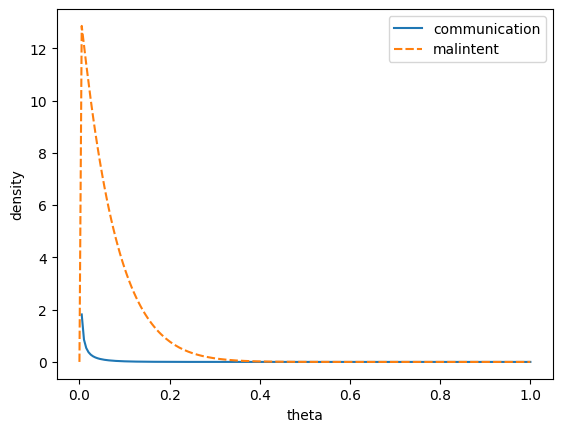

In [2]:
agents = [BayesianAgent(mu=0.01) for _ in range(10)]
for agent in agents:
    agent.set_cohort(agents)

# for example, the first agents parameters for the beta distribution to communicate with the second agent are:
_ = agents[0].plot_beta(agents[1], feature="both")

This distribution gets updated anytime the first agent interacts with the second. For example, if they repeatedly interact positively:

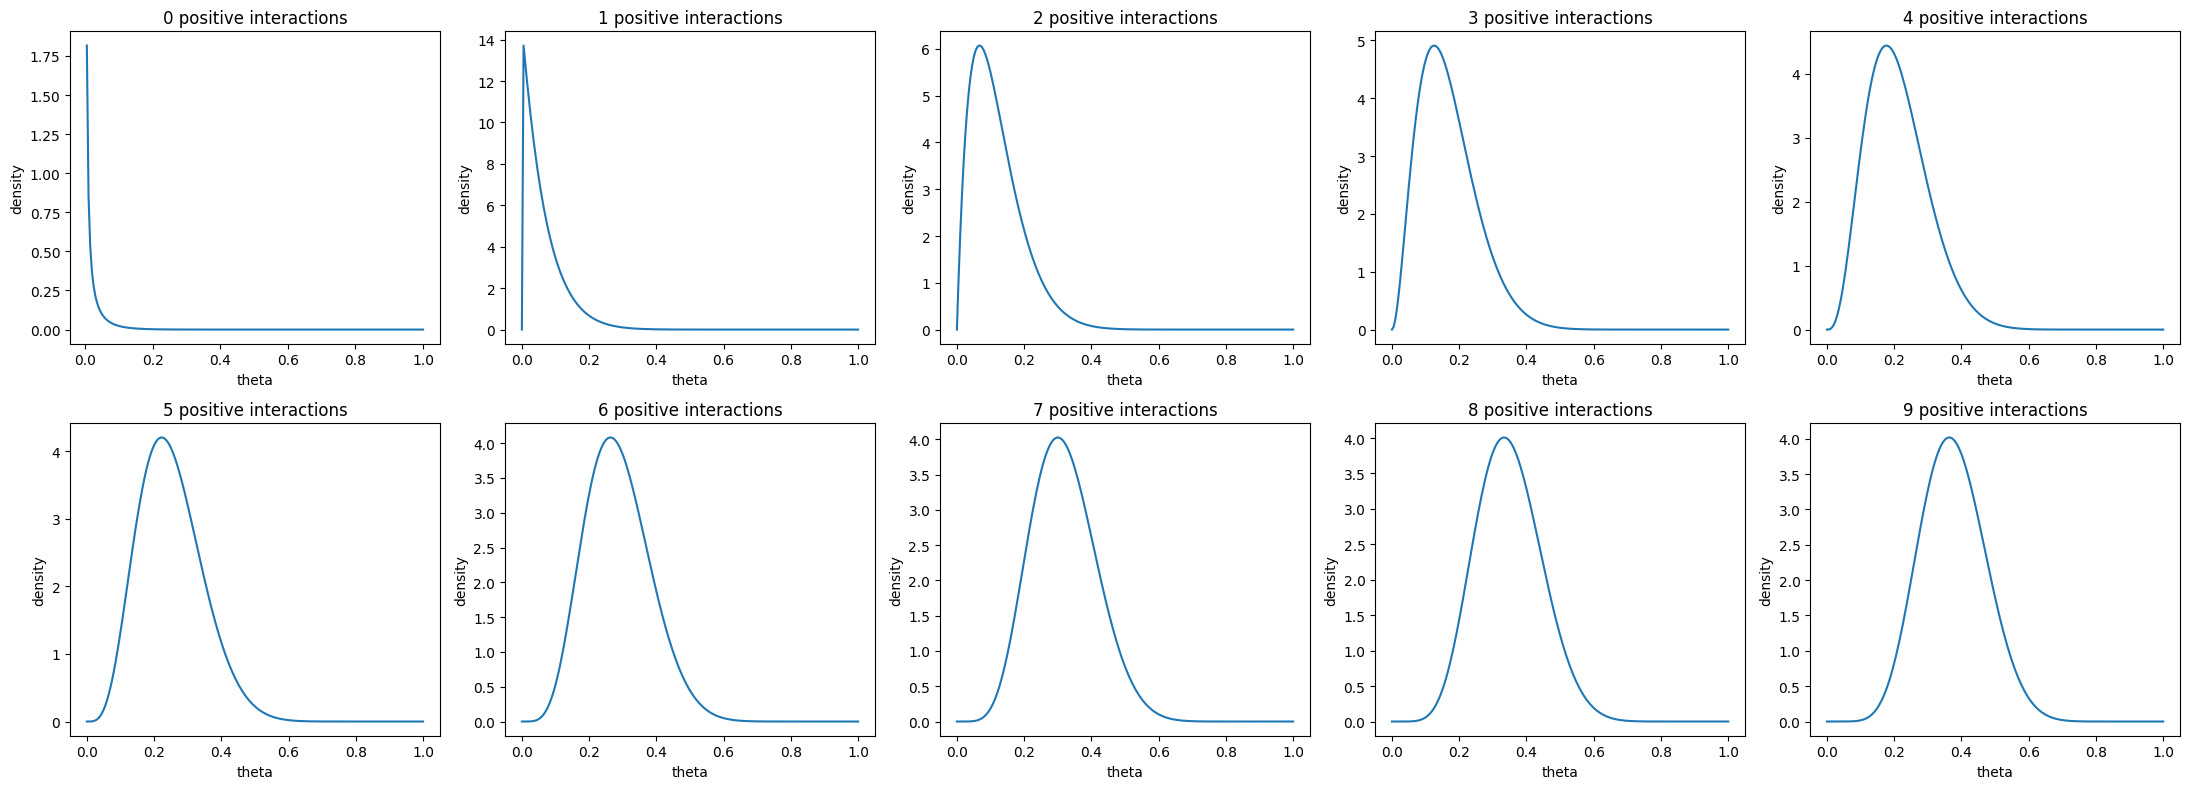

In [3]:
fig, ax = plt.subplots(2, 5, figsize = (22, 8))
beta_communicate = np.linspace(0,1,200)
for i in list(range(10)):
    a, b = agents[0].beta_communicate[agents[1]]
    _ = ax[int(i>4), i%5].plot(beta_communicate, st.beta.pdf(beta_communicate, a, b))
    _ = ax[int(i>4), i%5].set_xlabel("theta")
    _ = ax[int(i>4), i%5].set_ylabel("density")
    _ = ax[int(i>4), i%5].set_title(f"{i} positive interactions")
    agents[0].update_beta_communicate(agents[1], positive_outcome=True)
fig.tight_layout(w_pad=1, h_pad=1)

In [7]:
def reproduce(population: list[BayesianAgent], mu: float, size=1):
    offspring = []
    if len(population) > 2:
        for _ in range(size):
            while True:
                parent1 = random.choice(population)
                parent2 = random.choice(parent1.cohort)
                if st.bernoulli(parent1.likelihood_communicate(parent2)).rvs(1) and st.bernoulli(parent2.likelihood_communicate(parent1)).rvs(1):
                    offspring.append(BayesianAgent(mu, parents=(parent1, parent2)))
                    break
    return offspring

def simulate_bayesian_agents(num_food_opportunities: int, num_generations:int, population_size:int, gossip=False, intruders=False, mu=0.01, partitions=2, **class_variables):
    # adjust class variables if given:
    Agent.set_class_variables(**class_variables)
    # set up df to collect data:
    features = pd.DataFrame(columns=["generation", "feature", "type", "starvation"])
    # initialize first generation
    current_gen = [BayesianAgent(mu) for _ in range(population_size)]
    # for saving data about bayesian updating
    partitions = [round(i/partitions*num_generations) for i in range(partitions+1)]
    partitions[0] = 1
    saved_generations = {} # generation: list of agents
    for gen in tqdm(range(1, (num_generations+1))):
        if intruders and (gen in partitions[1:]):
            current_gen[10].malintent = 15
            current_gen[10].id = "intruder"
        for agent in current_gen:
            agent.set_cohort(current_gen)
        for food_opportunity in range(1, (num_food_opportunities+1)):
            # apply food decay and food opportunities:
            for agent in current_gen:
                agent.apply_food_decay()
                agent.found_food(other=np.random.choice(agent.cohort))
                # incorporate gossip (exchange of information)
                if gossip:
                    if len(agent.last_interaction) == 2:
                        other, pos_outcome = agent.last_interaction
                        recipient = np.random.choice(agent.cohort)
                        if other is not recipient:
                            recipient.incorporate_gossip(agent, other, pos_outcome)
            # starve agents every 5 generations if their food_counter drops too low:
            if food_opportunity % 5 == 0:
                current_gen = [agent for agent in current_gen if not agent.starve()]

        # record population level features/ statistics:
        communication, malintent, reputation = [], [], []
        for agent in current_gen:
            communication.append(agent.communication)
            malintent.append(agent.malintent)
            reputation.append(agent.reputation)
        features.loc[len(features.index)] = [gen, np.mean(communication) if len(current_gen) > 0 else None, "communication", (population_size-len(current_gen))]
        features.loc[len(features.index)] = [gen, np.mean(malintent) if len(current_gen) > 0 else None, "malintent", (population_size-len(current_gen))]
        if gen in partitions:
            saved_generations[gen] = [agent for agent in current_gen]

        # simulate reproduction with reputation:
        if gen < num_generations:
            current_gen = reproduce(current_gen, mu, size=population_size)
    return (saved_generations, features, partitions) if intruders else (saved_generations, features)


## First Simulation with Bayesian Agents

100%|██████████| 200/200 [07:39<00:00,  2.30s/it]


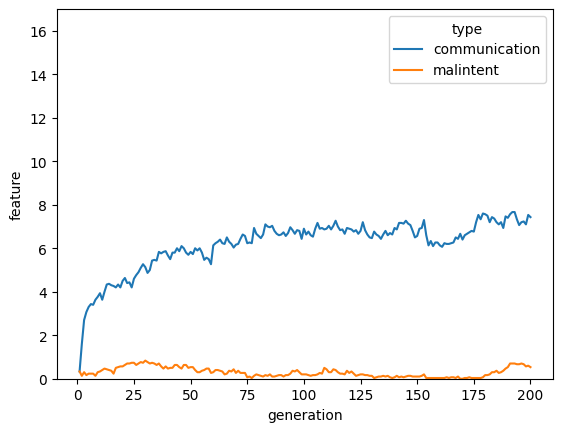

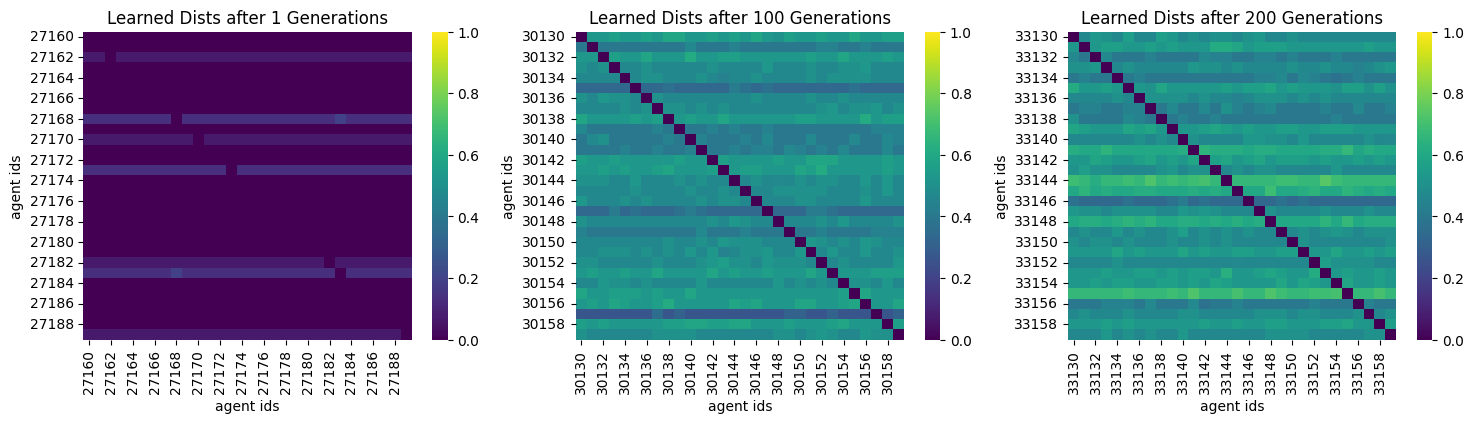

In [47]:
gens, sim_reputation = simulate_bayesian_agents(num_food_opportunities=30, num_generations=200, population_size=30, food_decay = 1.65)
plot_simulation_stats(sim_reputation)
plot_learned_distribution_matrix(gens)

### Using Gossip

100%|██████████| 200/200 [29:52<00:00,  8.96s/it] 


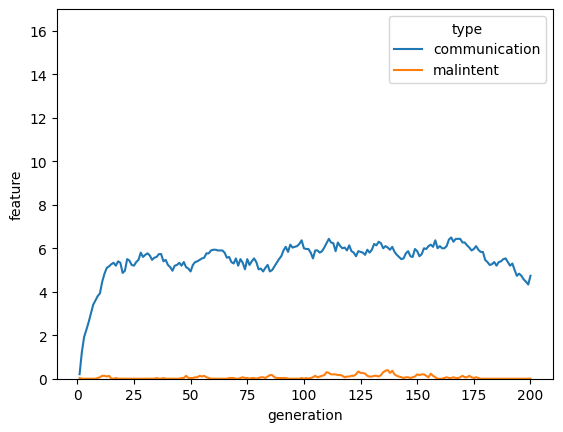

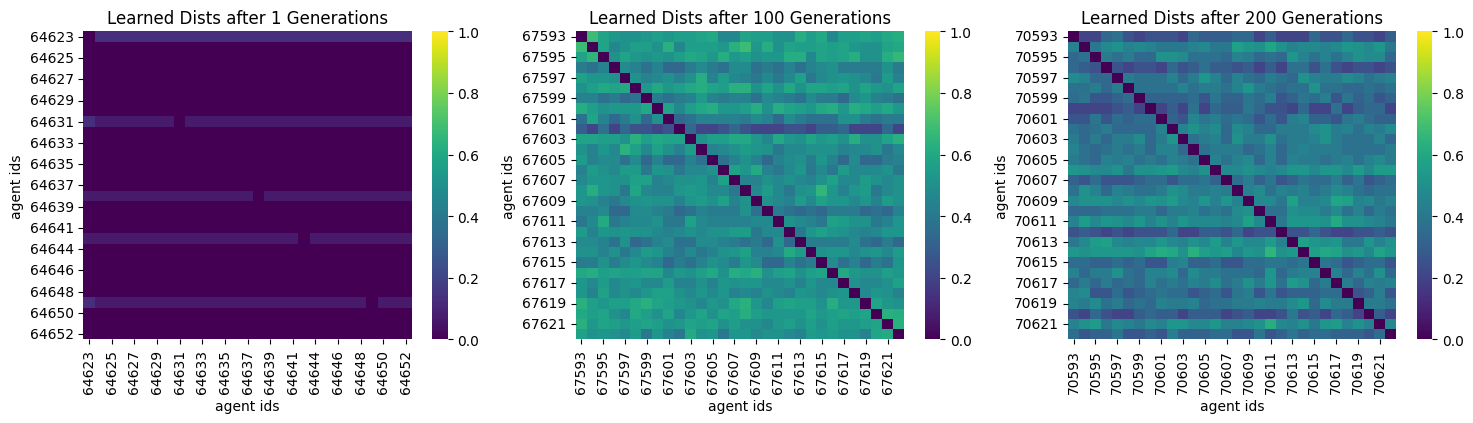

In [160]:
final_gen, sim_reputation = simulate_bayesian_agents(num_food_opportunities=100, num_generations=200, population_size=30, gossip=True, food_decay = 1.65)
plot_simulation_stats(sim_reputation)
plot_learned_distributions(final_gen)